In [3]:
import rasterio
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

Find All TIF Files

In [5]:
tif_files = list(Path('../data/viirs_data/NJ').glob('*.tif')) + \
            list(Path('../data/viirs_data/VT').glob('*.tif'))
print(f"Found {len(tif_files)} TIF files")

Found 1634 TIF files


Check Band Availability Across All Files

In [ ]:
summary = []
for tif_path in tif_files:
    with rasterio.open(tif_path) as src:
        filename = tif_path.stem
        state, date = filename.split('_')
        
        band1 = src.read(1)
        band2 = src.read(2)
        band3 = src.read(3)
        band4 = src.read(4)
        
        summary.append({
            'date': date,
            'state': state,
            'has_light_data': band2.max() > 0,
            'has_lunar_data': band1.max() > 0,
            'has_cloud_mask': band3.max() > 0,
            'has_band4_data': band4.max() > 0,
            'light_mean': band2.mean() if band2.max() > 0 else np.nan,
            'lunar_mean': band1.mean() if band1.max() > 0 else np.nan,
            'cloud_coverage': (band3 == 1).mean() if band3.max() > 0 else np.nan,
            'band4_mean': band4.mean() if band4.max() > 0 else np.nan,
        })

df_summary = pd.DataFrame(summary)

Output Summary Statistics

In [7]:
print("~~~~~ DATA AVAILABILITY SUMMARY ~~~~~")
print(f"Total files: {len(df_summary)}")
print(f"\nLight data (Band 2) present: {df_summary['has_light_data'].sum()} / {len(df_summary)}")
print(f"Lunar data (Band 1) present: {df_summary['has_lunar_data'].sum()} / {len(df_summary)}")
print(f"Cloud mask (Band 3) present: {df_summary['has_cloud_mask'].sum()} / {len(df_summary)}")
print(f"Band 4 data present: {df_summary['has_band4_data'].sum()} / {len(df_summary)}")

~~~~~ DATA AVAILABILITY SUMMARY ~~~~~
Total files: 1634

Light data (Band 2) present: 1601 / 1634
Lunar data (Band 1) present: 1544 / 1634
Cloud mask (Band 3) present: 962 / 1634
Band 4 data present: 1601 / 1634


Show Examples

In [8]:
print("\n~~~~~ DATES WITH LUNAR DATA ~~~~~")
print(df_summary[df_summary['has_lunar_data']].head())

print("\n~~~~~ DATES WITHOUT LUNAR DATA ~~~~~")
print(df_summary[~df_summary['has_lunar_data']].head())


~~~~~ DATES WITH LUNAR DATA ~~~~~
         date state  has_light_data  has_lunar_data  has_cloud_mask  \
1  2021-03-02    NJ            True            True            True   
2  2021-03-03    NJ            True            True            True   
3  2021-03-04    NJ            True            True            True   
4  2021-03-05    NJ            True            True            True   
5  2021-03-06    NJ            True            True            True   

   has_band4_data  light_mean  lunar_mean  cloud_coverage  band4_mean  
1            True   78.920182    9.336571        0.124514   55.945250  
2            True  346.869845    7.972903        0.128209   39.800955  
3            True  476.677315    4.747626        0.114094   27.600000  
4            True  378.280098    8.091707        0.156095   18.600000  
5            True  429.641978    7.657883        0.164533    2.509494  

~~~~~ DATES WITHOUT LUNAR DATA ~~~~~
           date state  has_light_data  has_lunar_data  has_cloud_mas

Load BirdCast Data

In [11]:
df_nj = pd.read_csv('../data/birdcast/birdcast_peak_data_NJ.csv')
df_vt = pd.read_csv('../data/birdcast/birdcast_peak_data_VT.csv')
df_nj['state'] = 'NJ'
df_vt['state'] = 'VT'
df_birds = pd.concat([df_nj, df_vt])
df_birds['date'] = pd.to_datetime(df_birds['date'])

print(f"\n~~~~~ BIRDCAST DATA ~~~~~")
print(f"Total BirdCast records: {len(df_birds)}")
print(f"Date range: {df_birds['date'].min()} to {df_birds['date'].max()}")
print(df_birds.head())


~~~~~ BIRDCAST DATA ~~~~~
Total BirdCast records: 1690
Date range: 2021-03-01 00:00:00 to 2025-11-04 00:00:00
        date total_passed peak_birds peak_direction peak_speed_mph  \
0 2021-03-01        10600      21500              —              -   
1 2021-03-02        65700      87900             NE           21.0   
2 2021-03-03        85500      72100             NE           23.0   
3 2021-03-04        10500      24100              —              -   
4 2021-03-05        10700      26000              —              -   

  peak_altitude_ft state  
0                -    NJ  
1            700.0    NJ  
2           1000.0    NJ  
3                -    NJ  
4                -    NJ  


Check Date Overlap

In [18]:
df_summary['date'] = pd.to_datetime(df_summary['date'])

# Which dates exist in both datasets?
viirs_dates = set(df_summary['date'])
bird_dates = set(df_birds['date'])
overlap_dates = viirs_dates & bird_dates

print(f"\n~~~~~ DATE OVERLAP ~~~~~")
print(f"VIIRS dates: {len(viirs_dates)}")
print(f"BirdCast dates: {len(bird_dates)}")
print(f"Overlapping dates: {len(overlap_dates)}")
print(f"VIIRS-only dates: {len(viirs_dates - bird_dates)}")
print(f"BirdCast-only dates: {len(bird_dates - viirs_dates)}")


~~~~~ DATE OVERLAP ~~~~~
VIIRS dates: 817
BirdCast dates: 845
Overlapping dates: 817
VIIRS-only dates: 0
BirdCast-only dates: 28


Visualize Data Availability

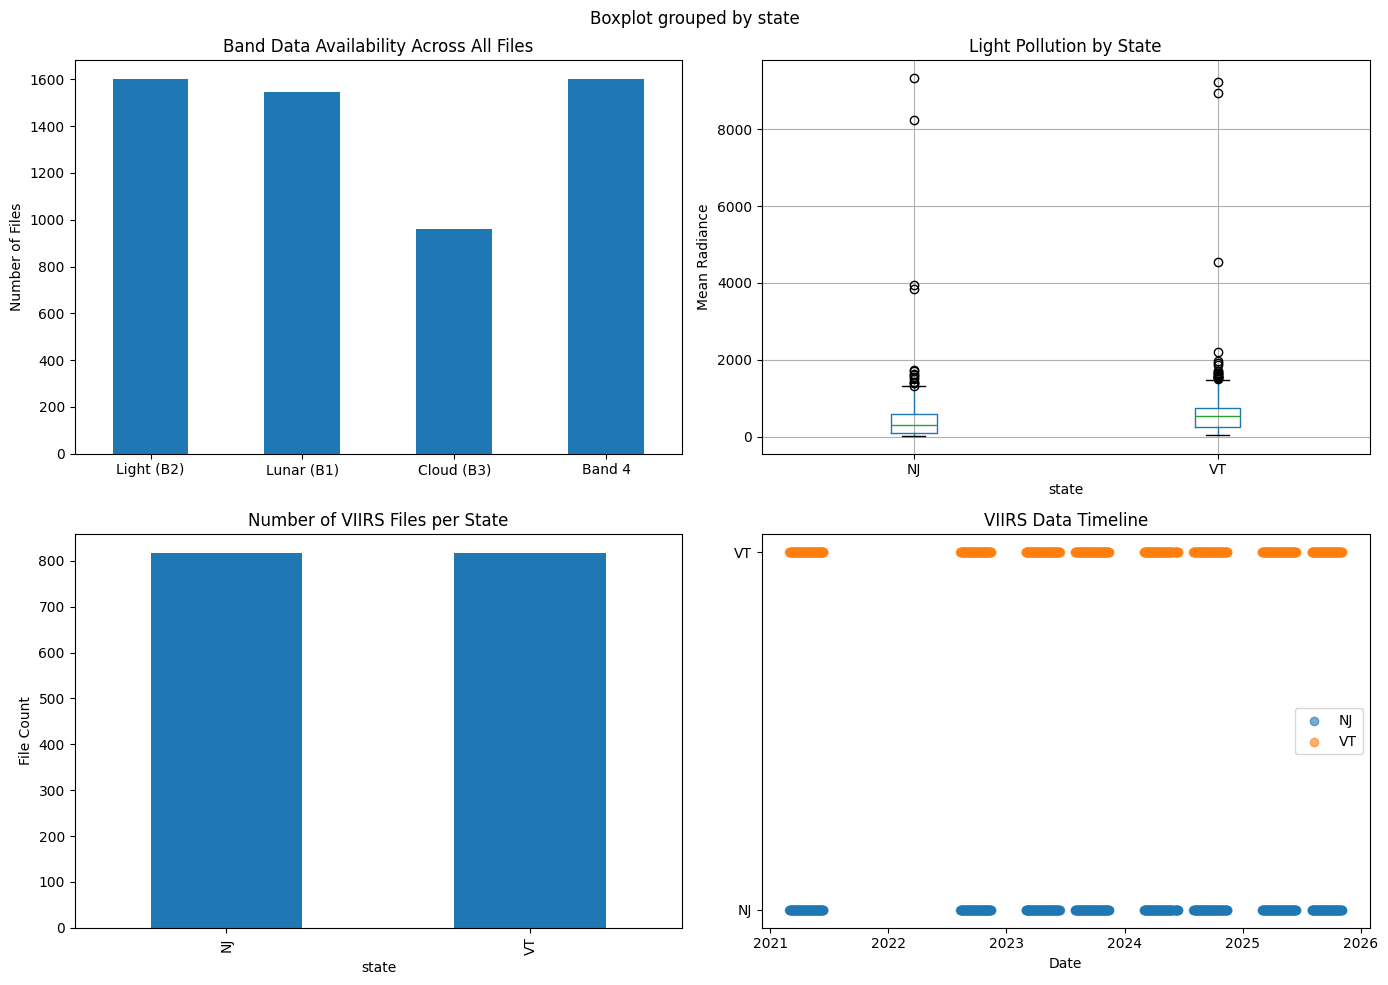

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Band availability
availability = df_summary[['has_light_data', 'has_lunar_data', 'has_cloud_mask', 'has_band4_data']].sum()
availability.plot(kind='bar', ax=axes[0,0], title='Band Data Availability Across All Files')
axes[0,0].set_ylabel('Number of Files')
axes[0,0].set_xticklabels(['Light (B2)', 'Lunar (B1)', 'Cloud (B3)', 'Band 4'], rotation=0)

# Light pollution distribution
df_summary.boxplot(column='light_mean', by='state', ax=axes[0,1])
axes[0,1].set_title('Light Pollution by State')
axes[0,1].set_ylabel('Mean Radiance')

# Temporal coverage
df_summary.groupby('state')['date'].count().plot(kind='bar', ax=axes[1,0], title='Number of VIIRS Files per State')
axes[1,0].set_ylabel('File Count')

# Date timeline
for state in ['NJ', 'VT']:
    state_data = df_summary[df_summary['state'] == state].sort_values('date')
    axes[1,1].scatter(state_data['date'], [state]*len(state_data), label=state, alpha=0.6)
axes[1,1].set_title('VIIRS Data Timeline')
axes[1,1].set_xlabel('Date')
axes[1,1].legend()

plt.tight_layout()
plt.savefig('../outputs/figures/data_quality/data_availability_overview.png', dpi=300)
plt.show()

Save Summary

In [22]:
df_summary.to_csv('../outputs/reports/tif_data_availability.csv', index=False)